# Image2StyleGAN Reproduction

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/internship/

/content/gdrive/MyDrive/internship


In [ ]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

     |████████████████████████████████| 204kB 20.7MB/s 
     |████████████████████████████████| 112kB 40.9MB/s 
     |████████████████████████████████| 26.9MB 103kB/s 


## Checking the pretrained model
    
We will load the necessary libraries to run the pretrained version

In [ ]:
# First set the base dir
!ls
!ls stuff/pretrained_models/

dnnlib			 latent_space_P.ipynb	 stuff
embedding_version.ipynb  semantic_editing.ipynb  torch_utils
ffhq.pkl


In [ ]:
# Import the needed libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch
from torchvision import models, transforms
import torch.optim as optim
from PIL import Image
import os
from torchvision.utils import save_image, make_grid
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!ls stuff/data/

expression01.png  sample01.png	sample03.png  sample05.png  sample07.png
expression02.png  sample02.png	sample04.png  sample06.png  sample08.png


In [ ]:
# Setting global attributes
RESOLUTION = 1024
#DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ITERATIONS = 4000
SAVE_STEP = 100

# OPTIMIZER
LEARNING_RATE = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-8

# GENERATOR
G_LAYERS = 18
Z_SIZE = 512

# IMAGE TO EMBED
#PATH_IMAGE = "stuff/data/expression02.png"
PATH_IMAGE = "stuff/data/sample03.png"
basename=os.path.basename(os.path.normpath(PATH_IMAGE)).split(".")[0]
SAVING_DIR = 'stuff/results/synthetic_images/'

In [ ]:
DEVICE

device(type='cuda', index=0)

## Loadding Pretrained Model
Load the pretrained model using the pickle file. I need the libraries `dnnlib` and `torch_utils` to load this model.

It does not need source code for the networks themselves — their class definitions are loaded from the pickle via `torch_utils.persistence`.


In [ ]:
PRETRAINED_MODEL = "stuff/pretrained_models/ffhq.pkl"

with open(PRETRAINED_MODEL, 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)  # torch.nn.Module

The pickle contains three networks. `'G'` and `'D'` are instantaneous snapshots taken during training, and `'G_ema'` represents a moving average of the generator weights over several training steps. The networks are regular instances of `torch.nn.Module`, with all of their parameters and buffers placed on the CPU at import and gradient computation disabled by default.

The generator consists of two submodules, `G.mapping` and `G.synthesis`, that can be executed separately. They also support various additional options:

```.python
w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, noise_mode='const', force_fp32=True)
```

Please refer to [`generate.py`](./generate.py), [`style_mixing.py`](./style_mixing.py), and [`projector.py`](./projector.py) for further examples.

From G we need to extract the `mapping` and the `synthesis` modules.

## Loss Function

The embedding algorithm selects a random initial latent code and optimize it using gradient descent. To do that, the authors defines a loss function based on VGG-16 perceptual loss and the pixel-wise MSE loss:

$$ w^{*}=\min _{w} L_{\text {percept }}(G(w), I)+\frac{\lambda_{m s e}}{N}\|G(w)-I\|_{2}^{2} $$

### VGG-16 perceptual loss
For the perceptual loss term $L_{\text {percept }}(\cdot)$

$$ L_{\text {percept }}\left(I_{1}, I_{2}\right)=\sum_{j=1}^{4} \frac{\lambda_{j}}{N_{j}}\left\|F_{j}\left(I_{1}\right)-F_{j}\left(I_{2}\right)\right\|_{2}^{2} $$

where $I_{1}, I_{2} \in \mathbb{R}^{n \times n \times 3}$ are the input images, $F_j$ is the feature output of VGG-16 layer `conv1_1`, `conv1_2`, `conv3_2` and `conv4_2` respectively, $N_j$ is the number of scalars in the $j^{th}$ layer output, $\lambda_j = 1$ for all js are empiracally obtained for good performance.

In [ ]:
# First explored the vgg16 module to check the convolutional layers
models.vgg16(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

We need to extract the feature maps after convolutional layers `conv1_1`, `conv1_2`, `conv3_2` and `conv4_2` respectively. 

* `conv1_1` : block 1 - convolution 1
* `conv1_2` : block 1 - convolution 2
* `conv3_2` : block 3 - convolution 2
* `conv4_2` : block 4 - convolution 2

In the previous pytorch module, these convolutional layers corresponds to indexes: 0 2 12 19, but we need to include the ReLu activation and all the previous layers. In this way, we have:

| indexes of layers | number of layers |
|:-----------------:|:----------------:|
|       [0,1]       |         2        |
|       [0,3]       |         4        |
|       [0,13]      |        14        |
|       [0,20]      |        21        |

Then we define a module that extract the respective feature maps:

In [ ]:
# Defining the VGG16 Perceptual Network

class PerceptualVGG16(torch.nn.Module):
    def __init__(self, requires_grad=False, n_layers=[2, 4, 14, 21]):
        super(PerceptualVGG16, self).__init__()
        
        # Dowsampling according to input of ImageNet 256x256
        self.upsample2d = torch.nn.Upsample(scale_factor=256/RESOLUTION, mode='bicubic')

        # Get the pretrained vgg16 model
        vgg_pretrained_features = models.vgg16(pretrained=True).features

        self.slice0 = torch.nn.Sequential()
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        
        # [0,1] layers indexes
        for x in range(n_layers[0]):  
            self.slice0.add_module(str(x), vgg_pretrained_features[x])\
            
        # [2, 3] layers indexes
        for x in range(n_layers[0], n_layers[1]):  # relu1_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        
        # [4, 13] layers indexes
        for x in range(n_layers[1], n_layers[2]): # relu3_2
            self.slice2.add_module(str(x), vgg_pretrained_features[x])

        # [14, 20] layers indexes
        for x in range(n_layers[2], n_layers[3]):# relu4_2
            self.slice3.add_module(str(x), vgg_pretrained_features[x])

        # Setting the gradients to false
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad=False
                
    def forward(self, x):
        upsample = self.upsample2d(x)
        
        h0 = self.slice0(upsample)
        h1 = self.slice1(h0)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)

        return h0, h1, h2, h3

Now we define our loss functions, and the function that will measure the loss

In [ ]:
# Pixel-Wise MSE Loss
MSE_Loss = nn.MSELoss(reduction="mean")

# VGG-16 perceptual loss
perceptual_net = PerceptualVGG16(n_layers=[2,4,14,21]).to(DEVICE)

In [ ]:
def calculate_loss(synth_img,original_img,perceptual_net,MSE_Loss):
    # calculate MSE Loss
    # (lamda_mse/N)*||G(w)-I||^2
    mse_loss = MSE_Loss(synth_img,original_img) 

    # calculate Perceptual Loss
    # sum_all (lamda_j / N) * ||F(I1) - F(I2)||^2
    real_0,real_1,real_2,real_3 = perceptual_net(original_img)
    synth_0,synth_1,synth_2,synth_3=perceptual_net(synth_img)

    perceptual_loss=0
    perceptual_loss+=MSE_Loss(synth_0,real_0)
    perceptual_loss+=MSE_Loss(synth_1,real_1)
    perceptual_loss+=MSE_Loss(synth_2,real_2)
    perceptual_loss+=MSE_Loss(synth_3,real_3)

    return mse_loss,perceptual_loss

## Embedding Latent and Optimizer Adam

In the article, the authors mention that they select a random initial latent code and optimize it using gradient descent. In this way, I define our tensor `embedding_latent` with gradients.

The paper also mentions that this embedding_latent can be initialized of different ways. Here, we have three options:

1. w+ all to zero 
2. w+ $\sim \mathcal{U}[-1,1]$ (random)
3. w+ $ = \bar{w}$ (the meant latent vector)

Then, I define the adam optimizer with the specification of the paper.

In [ ]:
n_samples = 5e5
def get_mean_latent():
  z = torch.randn((int(n_samples), 512), device=DEVICE)
  batch_size = int(1e5)

  w_mean = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  for i in range(int(n_samples/batch_size)):
    w = G.mapping(z[i*batch_size:(i+1)*batch_size,:], None)
    w = torch.sum(w, dim = 0).unsqueeze(0)
    w_mean = w_mean + w

  w_mean = w_mean / n_samples

  return w_mean.clone().detach().requires_grad_(True)

In [ ]:
# the embeding latent over the w+ laten spece
# the extended latent w+ contains array of size 512
# correspongin to the 18 layers in the generator.

# embedding to the mean latent vector
embedding_latent = get_mean_latent()

# embedding initializer to all zero
#embedding_latent = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)

# embedding intializer to uniform in [-1,1]
#embedding_latent = torch.cuda.FloatTensor(1,18,512).uniform_(-1,1).requires_grad_()
optimizer = optim.Adam({embedding_latent},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

## Preparing Data

Should I peform any preproccesing to the the images according to the paper?

In [ ]:
def image_reader(img_path,resize=None):

    with open(img_path,"rb") as f:
        image=Image.open(f)
        image=image.convert("RGB")
    if resize is not None:
        image=image.resize((resize,resize))
    transform = transforms.Compose([
    transforms.ToTensor()
    ])

    image = transform(image)


    image=image.unsqueeze(0)

    return image

In [ ]:
img=image_reader(PATH_IMAGE,resize=RESOLUTION)
img=img.to(DEVICE)
print(img.size())
print(torch.max(img))
print(torch.min(img))
print(basename)

torch.Size([1, 3, 1024, 1024])
tensor(0.9961, device='cuda:0')
tensor(0., device='cuda:0')
sample03


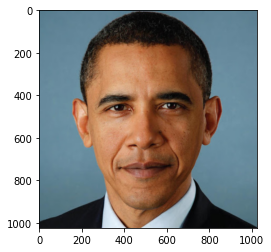

In [ ]:
plt.imshow(img.to('cpu').squeeze(0).permute(1, 2, 0))

In [ ]:
# checking the min and max of the generate image
synth_img = G.synthesis(embedding_latent, noise_mode='const', force_fp32=True)
print(synth_img.size())
print(torch.max(synth_img))
print(torch.min(synth_img))
#synth_img = (synth_img + 1.0) / 2.0

torch.Size([1, 3, 1024, 1024])
tensor(0.8761, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.9985, device='cuda:0', grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


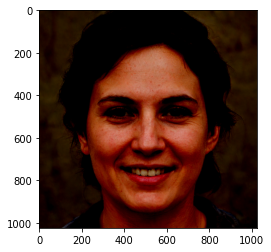

In [ ]:
plt.imshow(synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0))

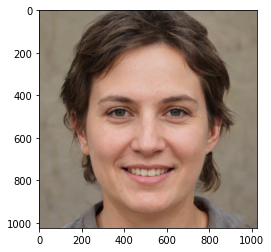

In [ ]:
# check what happend when + 1.0 and them divide to 2.0
synth_img = (synth_img + 1.0) / 2.0
plt.imshow(synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0))

## Embedding one image


In this process, we try to adjust the embedding_latent in such a way that the synthetic image is the same as the original image. To do that, we follow the net steps: 

1. Feed the pretrained generator with the embedding latent and get the synthetic image
2. Calculate the loss between the synthetic image and the original image
2. Backward the gradients and apply the optimization

Note: additionally we save the generated image, and the current embedding_latent every 100 steps

In [ ]:
print("Starting Embedding")
loss_list=[]
loss_mse=[]
loss_perceptual=[]
latent_list = {}
for i in range(0,ITERATIONS):
    # reset the gradients
    optimizer.zero_grad()

    # get the synthetic image
    synth_img = G.synthesis(embedding_latent, noise_mode='const', force_fp32=True)
    synth_img = (synth_img + 1.0) / 2.0
    
    # get the loss and backpropagate the gradients
    mse_loss,perceptual_loss = calculate_loss(synth_img,img, perceptual_net, MSE_Loss)
    loss = mse_loss + perceptual_loss
    loss.backward()

    optimizer.step()

    # store the losses metrics
    loss_list.append(loss.item())
    loss_mse.append(mse_loss.item())
    loss_perceptual.append(perceptual_loss.item())

    # every SAVE_STEP, I store the current latent
    if (i +1) % SAVE_STEP == 0:
        print('iter[%d]:\t loss: %.4f\t mse_loss: %.4f\tpercep_loss: %.4f' % (i+1,  loss.item(), mse_loss.item(), perceptual_loss.item()))
        latent_list[str(i+1)] = embedding_latent.detach().cpu().numpy()

# store all the embeddings create during optimization in .npz
path_embedding_latent = os.path.join(SAVING_DIR, "latents/{}_latents_iters_{}_step_{}.npz".format(basename,str(ITERATIONS).zfill(6),str(SAVE_STEP).zfill(4)))
print("Saving: {}".format(path_embedding_latent))
np.savez(path_embedding_latent, **latent_list)

Starting Embedding
iter[100]:	 loss: 1.6002	 mse_loss: 0.0088	percep_loss: 1.5914
iter[200]:	 loss: 1.1065	 mse_loss: 0.0053	percep_loss: 1.1012
iter[300]:	 loss: 0.8437	 mse_loss: 0.0038	percep_loss: 0.8399
iter[400]:	 loss: 0.7026	 mse_loss: 0.0033	percep_loss: 0.6992
iter[500]:	 loss: 0.6161	 mse_loss: 0.0031	percep_loss: 0.6130
iter[600]:	 loss: 0.5627	 mse_loss: 0.0031	percep_loss: 0.5597
iter[700]:	 loss: 0.5312	 mse_loss: 0.0029	percep_loss: 0.5283
iter[800]:	 loss: 0.5104	 mse_loss: 0.0029	percep_loss: 0.5074
iter[900]:	 loss: 0.4879	 mse_loss: 0.0028	percep_loss: 0.4851
iter[1000]:	 loss: 0.4796	 mse_loss: 0.0027	percep_loss: 0.4769
iter[1100]:	 loss: 0.4622	 mse_loss: 0.0028	percep_loss: 0.4593
iter[1200]:	 loss: 0.4511	 mse_loss: 0.0027	percep_loss: 0.4484
iter[1300]:	 loss: 0.4397	 mse_loss: 0.0027	percep_loss: 0.4370
iter[1400]:	 loss: 0.4332	 mse_loss: 0.0028	percep_loss: 0.4304
iter[1500]:	 loss: 0.4260	 mse_loss: 0.0025	percep_loss: 0.4235
iter[1600]:	 loss: 0.4151	 mse

A suitable loss is around 0.4 to 0.45

### Loss per Iteration

In [ ]:
# Function to plot the loss per iteration
def plot_loss(save = False):
  plt.figure(figsize=(10,5))
  plt.title("Loss During Embedding")
  plt.plot(loss_list,label="Loss")
  plt.plot(loss_mse,label="MSE Loss")
  plt.plot(loss_perceptual,label="Perceptual Loss")
  plt.xlabel("Optimization Steps")
  plt.ylabel("Loss")
  plt.legend()
  

  if save:
    file_dir = os.path.join(SAVING_DIR, "loss_plots/{}_losses_iters_{}.png".format(basename, str(ITERATIONS).zfill(6)))
    print("Saving: {}".format(file_dir))
    plt.savefig(file_dir)
    
  plt.show()

Saving: stuff/results/synthetic_images/loss_plots/sample03_losses_iters_004000.png


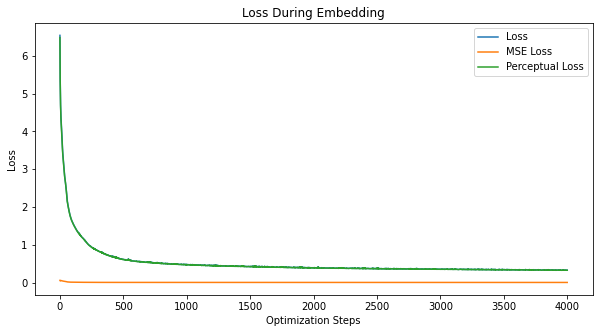

In [ ]:
plot_loss(True)

### Generated images per iteration

Now, we are going to check the synthetic images generate by the generator in specific iterations (optimization steps)

In [ ]:
# Function to load the latents from the saved .npz file
def load_latents(file_name, display_latents = False):
  latent_embeddings_saved = os.path.join(SAVING_DIR, "latents/"+file_name)

  dictionary = {}
  with open(latent_embeddings_saved, 'rb') as f:
      container = np.load(f)
      
      for iter, latent in container.items():
          dictionary[iter] = latent
          if display_latents:
            print("iter: {} -- latent_code shape: {}".format(iter,latent.shape))
            print(latent[0,0,-5:])
  return dictionary

In [ ]:
#Checking the stored .npz
!ls $SAVING_DIR/latents

expression01_latents_iters_002000_step_0100.npz
expression02_latents_iters_002000_step_0100.npz
sample03_latents_iters_000100_step_0010.npz
sample03_latents_iters_001500_step_0100.npz
sample03_latents_iters_002000_step_0100.npz
sample03_latents_iters_012000_step_0500.npz
sample05_latents_iters_001500_step_0100.npz
sample05_latents_iters_005000_step_0100.npz
sample06_latents_iters_025000_step_0100.npz
sample08_latents_iters_005000_step_0100.npz
sample08_latents_iters_015000_step_0100.npz


In [ ]:
latent_codes = load_latents("sample03_latents_iters_000100_step_0010.npz")

In [ ]:
def show_images_results(latent_codes, iterations_to_show, save = False):

    saved_iterations = list(latent_codes.keys())
    iterations_to_show_filter = [iter for iter in iterations_to_show if str(iter) in saved_iterations]

    n_images = len(iterations_to_show_filter) + 1
    inches = 4
    fig, axs = plt.subplots(1,n_images,figsize=(inches * n_images , inches))

    # original image
    with open(PATH_IMAGE,"rb") as f:
        image=Image.open(f)
        axs[0].imshow(image)
        axs[0].set_title('Original')
        axs[0].axis('off')

    # embeddings per iterations
    idx = 1
    for iter in iterations_to_show:
      latent = latent_codes.get(str(iter))

      if latent is not None:
        tensor_latent = torch.tensor(latent).to(DEVICE)
        synth_img = G.synthesis(tensor_latent, noise_mode='const', force_fp32=True)
        synth_img = (synth_img + 1.0) / 2.0
        synth_img = synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0)       
        axs[idx].imshow(synth_img.clamp(0,1))
        axs[idx].set_title("Iteration: {}".format(str(iter)))
        axs[idx].axis('off')

        idx += 1
      else:
        print("Iteration {} is not stored in file".format(iter))

    if save:
      file_dir = os.path.join(SAVING_DIR, "images/{}_images_{}_to_{}.png".format(
          basename,
          iterations_to_show_filter[0],
          iterations_to_show_filter[-1]))
      print("Saving: {}".format(file_dir))
      plt.savefig(file_dir)
            

Saving: stuff/results/synthetic_images/images/sample03_images_100_to_4000.png


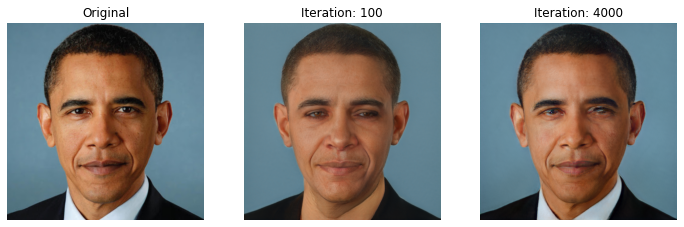

In [ ]:
latent_codes = load_latents("sample03_latents_iters_004000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 4000], save = True)

Saving: stuff/results/synthetic_images/images/sample03_images_10_to_100.png


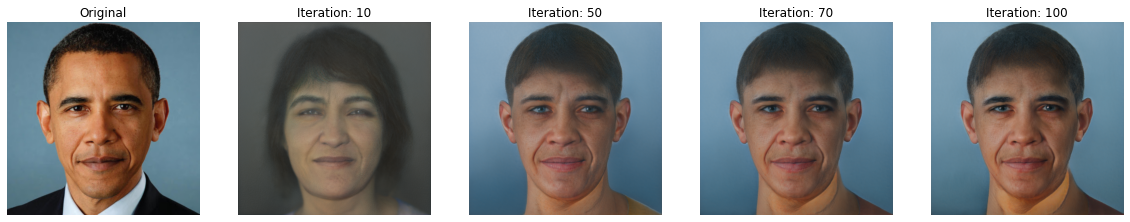

In [ ]:
latent_codes = load_latents("sample03_latents_iters_000100_step_0010.npz")
show_images_results(latent_codes, iterations_to_show = [10, 50, 70, 100], save = True)

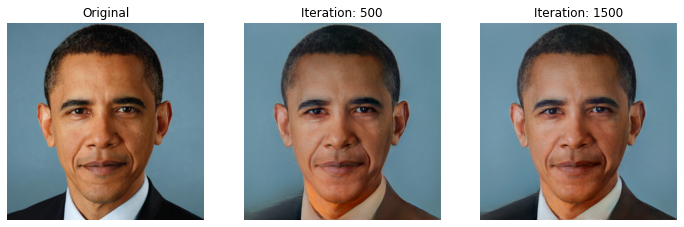

In [ ]:
latent_codes = load_latents("sample03_latents_iters_012000_step_0500.npz")
show_images_results(latent_codes, iterations_to_show = [500, 1000, 1500]) #, save = True)

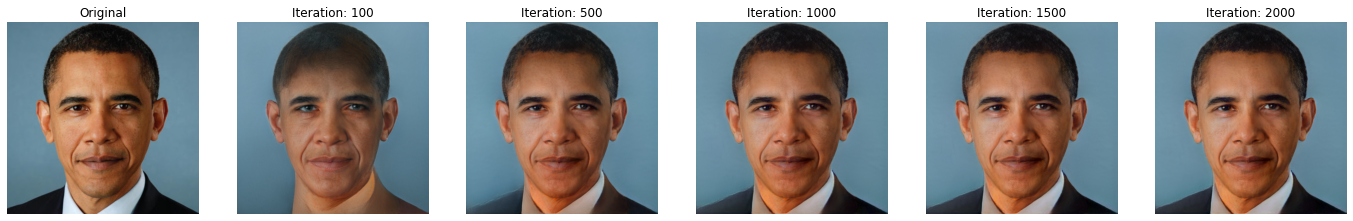

In [ ]:
latent_codes = load_latents("sample03_latents_iters_002000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 500, 1000, 1500, 2000]) #, save = True)

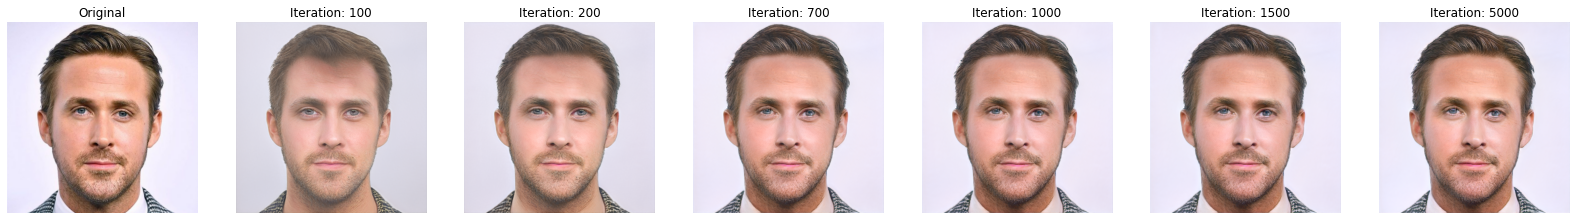

In [ ]:
latent_codes = load_latents("sample05_latents_iters_005000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 700 , 1000, 1500, 5000]) #, save = True)

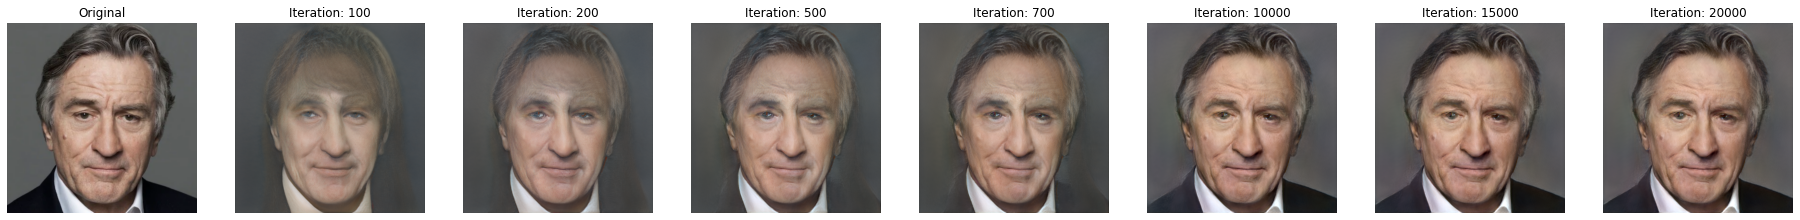

In [ ]:
latent_codes = load_latents("sample08_latents_iters_020000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 500, 700 , 10000, 15000, 20000]) #, save = True)


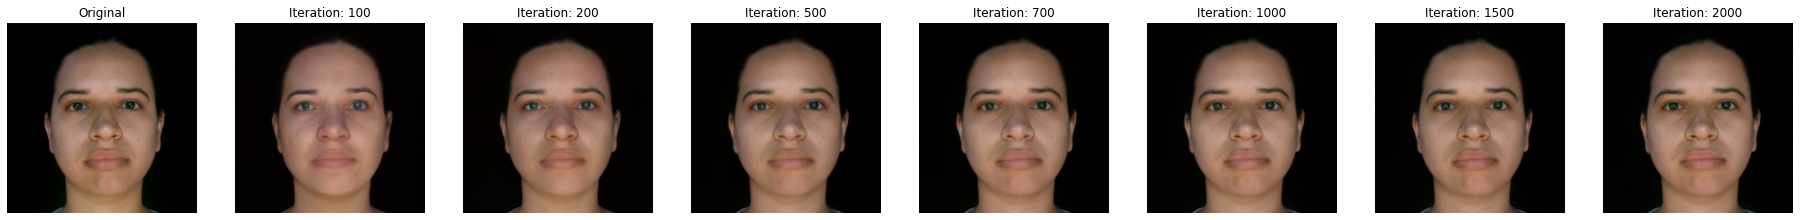

In [ ]:
latent_codes = load_latents("expression01_latents_iters_002000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 500, 700 , 1000, 1500, 2000]) #, save = True)


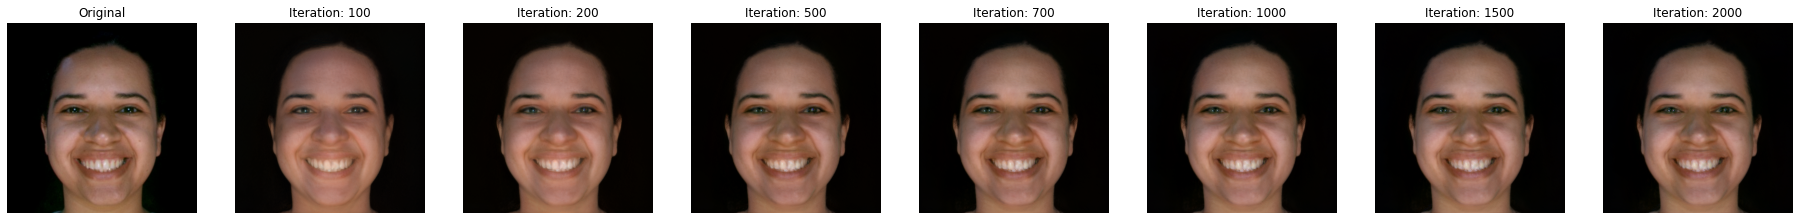

In [ ]:
latent_codes = load_latents("expression02_latents_iters_002000_step_0100.npz")
show_images_results(latent_codes, iterations_to_show = [100, 200, 500, 700 , 1000, 1500, 2000]) #, save = True)